# ICL evluation beased on LongBench

In [1]:
import pandas as pd
import time
from openai import OpenAI
from tqdm import tqdm
import os

foler_path = "Paper Experiment Results/New_filtered/ICL"
file_name = "exp_result_Meta-Llama-3-70B-Instruct_20240531140350_951758.csv"
output_file_name = file_name.replace(".csv", "_evaluated.csv")
input_path = os.path.join(foler_path, file_name)
output_path = os.path.join(foler_path, output_file_name)
_data = pd.read_csv(input_path)
eval_model = "gpt-3.5-turbo-0125"
api_key = os.getenv("OPENAI_API_KEY")
client = OpenAI(api_key=api_key)
temperature = 0

In [2]:
def extract_final_response(response, prompt):
    return response[len(prompt) :]


def match_prompt_column(model):
    if "Llama-2" in model:
        return "llama2_chat_initial_prompt"
    elif "Mixtral" in model or "Mistral" in model:
        return "mixtral_instruct_initial_prompt"
    elif "Llama-3" in model:
        return "llama3_chat_initial_prompt"
    else:
        print("The model name didn't match anything, please check!!!!")
        return None


def extract_pure_response(row):
    model = row["model"]
    prompt_column = match_prompt_column(model)
    response = row["generated_response"]
    prompt = row[prompt_column]
    return extract_final_response(response=response, prompt=prompt)


def process_string(input_string):
    processed_string = input_string.strip("[]").replace("\\", "")
    questions = processed_string.split("\n")
    questions = [q.strip("'") for q in questions]
    return questions


_data["pure_response"] = _data.apply(extract_pure_response, axis=1)

In [3]:
import re
import string
from collections import Counter


def classification_score(prediction, ground_truth, all_classes):
    em_match_list = []
    for class_name in all_classes:
        if class_name in prediction:
            em_match_list.append(class_name)
    for match_term in em_match_list:
        if match_term in ground_truth and match_term != ground_truth:
            em_match_list.remove(match_term)
    if ground_truth in em_match_list:
        score = 1.0 / len(em_match_list)
    else:
        score = 0.0
    return score


def normalize_answer(s):
    """Lower text and remove punctuation, articles and extra whitespace."""

    def remove_articles(text):
        return re.sub(r"\b(a|an|the)\b", " ", text)

    def white_space_fix(text):
        return " ".join(text.split())

    def remove_punc(text):
        exclude = set(string.punctuation)
        return "".join(ch for ch in text if ch not in exclude)

    def lower(text):
        return text.lower()

    return white_space_fix(remove_articles(remove_punc(lower(s))))


def f1_score(prediction, ground_truth, **kwargs):
    common = Counter(prediction) & Counter(ground_truth)
    num_same = sum(common.values())
    if num_same == 0:
        return 0
    precision = 1.0 * num_same / len(prediction)
    recall = 1.0 * num_same / len(ground_truth)
    f1 = (2 * precision * recall) / (precision + recall)
    return f1


def qa_f1_score(prediction, ground_truth):
    normalized_prediction = normalize_answer(prediction)
    normalized_ground_truth = normalize_answer(ground_truth)

    prediction_tokens = normalized_prediction.split()
    ground_truth_tokens = normalized_ground_truth.split()
    return f1_score(prediction_tokens, ground_truth_tokens)


def calculate_classification_score(row, all_classes):
    prediction = row["pure_response"]
    answer = row["answers"].strip("[]' ")
    score = classification_score(prediction, answer, all_classes)
    return score


def calculate_qa_f1_score(row):
    prediction = row["pure_response"]
    answer = row["answers"]
    score = qa_f1_score(prediction=prediction, ground_truth=answer)
    return score

In [4]:
trec_dataset = _data[_data["dataset_name"] == "trec"]
triviaqa = _data[_data["dataset_name"] == "triviaqa"]

trec_dataset["classification_score"] = trec_dataset.apply(
    calculate_classification_score, args=(categories,), axis=1
)

triviaqa["qa_f1_score"] = triviaqa.apply(calculate_qa_f1_score, axis=1)
merged_dataset = pd.concat([trec_dataset, triviaqa])

/tmp/ipykernel_1925454/156266619.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trec_dataset["classification_score"] = trec_dataset.apply(
/tmp/ipykernel_1925454/156266619.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  triviaqa["qa_f1_score"] = triviaqa.apply(calculate_qa_f1_score, axis=1)


In [5]:
merged_dataset.to_csv(output_path, index=False)

In [235]:
merged_dataset.shape

(1015, 29)

In [236]:
trec_dataset = merged_dataset[merged_dataset["dataset_name"] == "trec"]

In [237]:
trec_dataset.classification_score

0      1.0
1      1.0
2      0.0
3      1.0
4      1.0
      ... 
945    1.0
946    1.0
947    1.0
948    1.0
949    0.0
Name: classification_score, Length: 560, dtype: float64

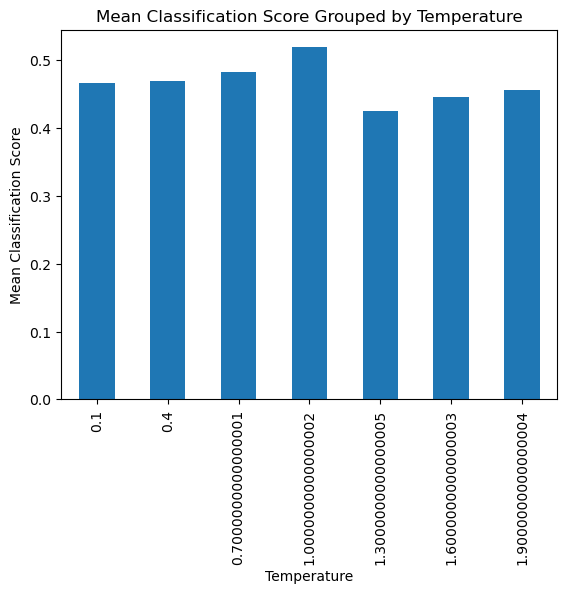

In [238]:
import matplotlib.pyplot as plt

grouped_data = trec_dataset.groupby("Temperature")["classification_score"].mean()
grouped_data.plot(kind="bar")
plt.xlabel("Temperature")
plt.ylabel("Mean Classification Score")
plt.title("Mean Classification Score Grouped by Temperature")
plt.show()

# Analysis Integrated

In [1]:
import os
import datetime
import pandas as pd
import matplotlib.pyplot as plt

current_time = datetime.datetime.now()
current_time_str = current_time.strftime("%Y%m%d%H%M%S")
model_weight_sizes = {
    "Llama-2-13b-chat-hf": 13,
    "Mistral-7B-Instruct-v0.2": 7,
    "Llama-2-70b-chat-hf": 70,
    "Meta-Llama-3-8B-Instruct": 8,
    "Llama-2-7b-chat-hf": 7,
    "Mixtral-8x7B-Instruct-v0.1": 56,
}

folder_path = "Paper Experiment Results/New_filtered/ICL"
output_photo_name = f"ICL_{current_time_str}.svg"
output_photo_path = os.path.join(folder_path, output_photo_name)
all_dfs = []
for filename in os.listdir(folder_path):
    if filename.endswith(".csv") and "evaluated" in filename:
        file_path = os.path.join(folder_path, filename)
        df = pd.read_csv(file_path)
        model_name = filename.split("_")[2]
        df["model_name"] = model_name
        df["weight_size"] = model_weight_sizes.get(model_name, None)
        all_dfs.append(df)

df = pd.concat(all_dfs, ignore_index=True)

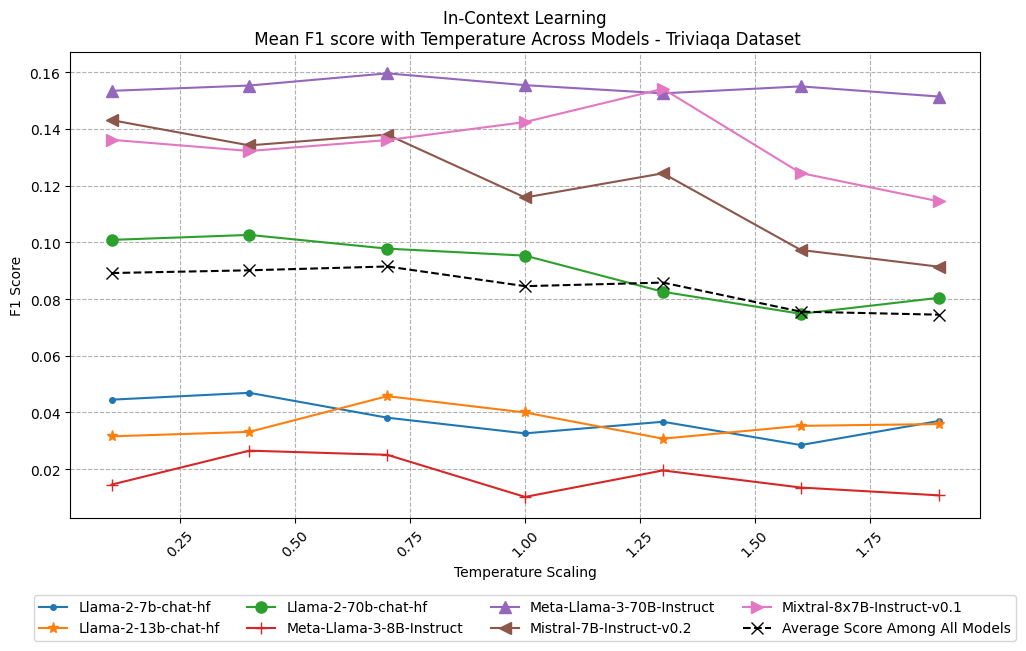

In [2]:
df1 = df[df["dataset_name"] == "triviaqa"]
grouped_data = df1.groupby(["model", "Temperature"])["qa_f1_score"].mean()

models = [
    "Llama-2-7b-chat-hf",
    "Llama-2-13b-chat-hf",
    "Llama-2-70b-chat-hf",
    "Meta-Llama-3-8B-Instruct",
    "Meta-Llama-3-70B-Instruct",
    "Mistral-7B-Instruct-v0.2",
    "Mixtral-8x7B-Instruct-v0.1",
]

markers = [
    ".",
    "*",
    "o",
    "+",
    "^",
    "<",
    ">",
    "8",
    "s",
    "p",
    ",",
    "v",
    "D",
    "d",
    "x",
    "|",
    "_",
]

plt.figure(figsize=(10, 6))
for i, model in enumerate(models):
    model_data = grouped_data[model]
    marker = markers[i % len(markers)]  # Select marker cyclically from the list
    plt.plot(
        model_data.index.get_level_values("Temperature"),
        model_data,
        marker=marker,
        markersize=8,
        label=model,
    )

grouped_data_temperature = df.groupby(["Temperature"])["qa_f1_score"].mean()
plt.plot(
    grouped_data_temperature.index,
    grouped_data_temperature,
    linestyle="--",
    marker="x",
    markersize=8,
    color="black",
    label="Average Score Among All Models",
)

plt.xlabel("Temperature Scaling")
plt.ylabel("F1 Score")
plt.title(
    "In-Context Learning\n Mean F1 score with Temperature Across Models - Triviaqa Dataset"
)
plt.grid(
    linestyle="--",
)
plt.xticks(rotation=45)
plt.tight_layout()

plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=4)
plt.savefig(output_photo_path, format="svg", bbox_inches="tight")
plt.show()

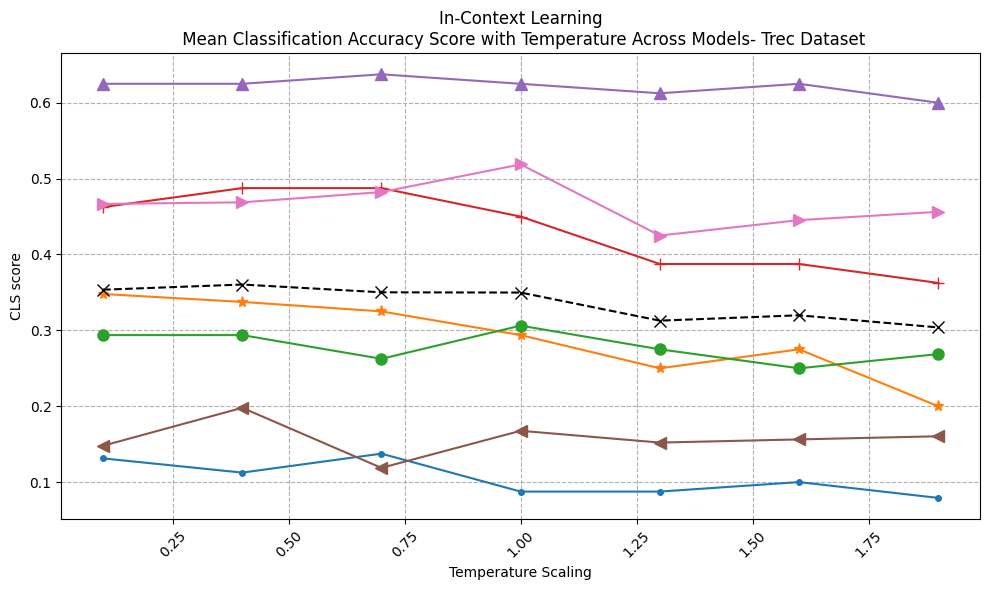

In [7]:
df2 = df[df["dataset_name"] == "trec"]
grouped_data = df2.groupby(["model", "Temperature"])["classification_score"].mean()

models = [
    "Llama-2-7b-chat-hf",
    "Llama-2-13b-chat-hf",
    "Llama-2-70b-chat-hf",
    "Meta-Llama-3-8B-Instruct",
    "Meta-Llama-3-70B-Instruct",
    "Mistral-7B-Instruct-v0.2",
    "Mixtral-8x7B-Instruct-v0.1",
]

markers = [
    ".",
    "*",
    "o",
    "+",
    "^",
    "<",
    ">",
    "8",
    "s",
    "p",
    ",",
    "v",
    "D",
    "d",
    "x",
    "|",
    "_",
]

plt.figure(figsize=(10, 6))
for i, model in enumerate(models):
    model_data = grouped_data[model]
    marker = markers[i % len(markers)]  # Select marker cyclically from the list
    plt.plot(
        model_data.index.get_level_values("Temperature"),
        model_data,
        marker=marker,
        markersize=8,
        label=model,
    )

grouped_data_temperature = df.groupby(["Temperature"])["classification_score"].mean()
plt.plot(
    grouped_data_temperature.index,
    grouped_data_temperature,
    linestyle="--",
    marker="x",
    markersize=8,
    color="black",
    label="Average Score Among All Models",
)

plt.xlabel("Temperature Scaling")
plt.ylabel("CLS score")
plt.title(
    "In-Context Learning\n Mean Classification Accuracy Score with Temperature Across Models- Trec Dataset"
)
plt.grid(
    linestyle="--",
)
plt.xticks(rotation=45)
plt.tight_layout()

# plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=4)
plt.savefig(output_photo_path, format="svg", bbox_inches="tight")
plt.show()

In [8]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

scaler = MinMaxScaler()
df["qa_f1_score_normalized"] = scaler.fit_transform(df[["qa_f1_score"]])
df["classification_score_normalized"] = scaler.fit_transform(
    df[["classification_score"]]
)
df["composite_score"] = np.where(
    df["qa_f1_score"].notnull(), df["qa_f1_score"], df["classification_score"]
)

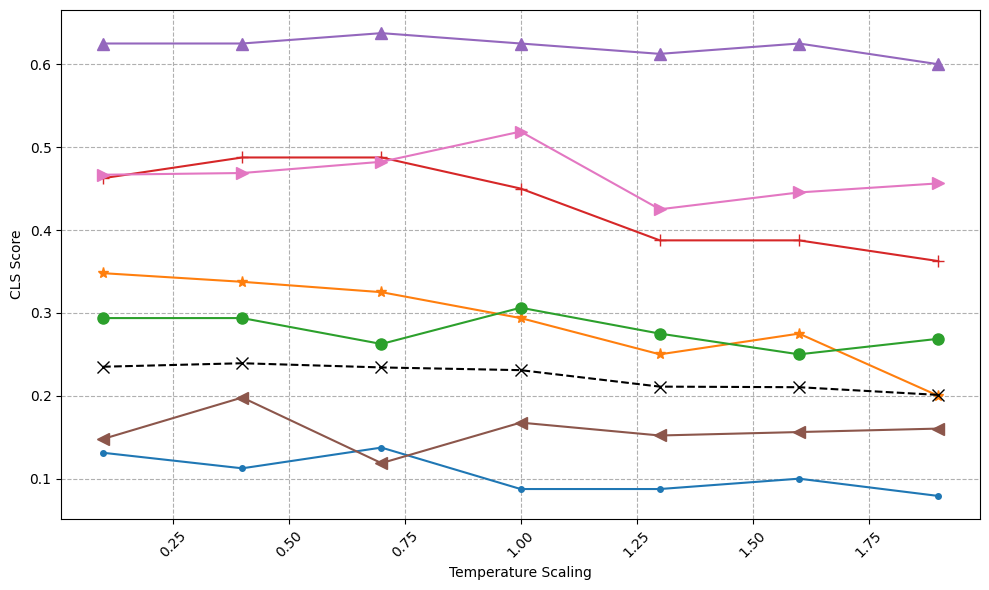

In [11]:
df2 = df[df["dataset_name"] == "trec"]
grouped_data = df2.groupby(["model", "Temperature"])["composite_score"].mean()

models = [
    "Llama-2-7b-chat-hf",
    "Llama-2-13b-chat-hf",
    "Llama-2-70b-chat-hf",
    "Meta-Llama-3-8B-Instruct",
    "Meta-Llama-3-70B-Instruct",
    "Mistral-7B-Instruct-v0.2",
    "Mixtral-8x7B-Instruct-v0.1",
]

markers = [
    ".",
    "*",
    "o",
    "+",
    "^",
    "<",
    ">",
    "8",
    "s",
    "p",
    ",",
    "v",
    "D",
    "d",
    "x",
    "|",
    "_",
]

plt.figure(figsize=(10, 6))
for i, model in enumerate(models):
    model_data = grouped_data[model]
    marker = markers[i % len(markers)]  # Select marker cyclically from the list
    plt.plot(
        model_data.index.get_level_values("Temperature"),
        model_data,
        marker=marker,
        markersize=8,
        label=model,
    )

grouped_data_temperature = df.groupby(["Temperature"])["composite_score"].mean()
plt.plot(
    grouped_data_temperature.index,
    grouped_data_temperature,
    linestyle="--",
    marker="x",
    markersize=8,
    color="black",
    label="Average Score Among All Models",
)

plt.xlabel("Temperature Scaling")
plt.ylabel("CLS Score")
# plt.title("In-context Learning\n Mean Normalized Score with Temperature Across Models")
plt.grid(
    linestyle="--",
)
plt.xticks(rotation=45)
plt.tight_layout()

# plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=4)
plt.savefig(output_photo_path, format="svg", bbox_inches="tight")
# plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=4)
plt.show()

In [10]:
from scipy.stats import kendalltau
import statsmodels.api as sm
import numpy as np
from sklearn.metrics import mean_squared_error
from scipy.stats import spearmanr
from scipy.stats import pearsonr

models = [
    "Llama-2-7b-chat-hf",
    "Llama-2-13b-chat-hf",
    "Llama-2-70b-chat-hf",
    "Meta-Llama-3-8B-Instruct",
    "Meta-Llama-3-70B-Instruct",
    "Mistral-7B-Instruct-v0.2",
    "Mixtral-8x7B-Instruct-v0.1",
]

results = []
for model_name in models:
    model_data = df[df["model"] == model_name]
    temperatures = model_data["Temperature"].values
    accuracy = model_data["composite_score"].values

    # 计算 Spearman 相关系数和 p 值
    corr, p_value = spearmanr(temperatures, accuracy)

    # 添加常数项并拟合 OLS 模型
    temperatures = sm.add_constant(temperatures)
    model = sm.OLS(accuracy, temperatures).fit()

    # 计算预测值和标准误差
    predictions = model.predict(temperatures)
    se = np.sqrt(mean_squared_error(accuracy, predictions))

    # 获取 R^2 和调整后的 R^2
    r_squared = model.rsquared
    r_squared_adj = model.rsquared_adj

    # 获取回归系数
    beta_hat = model.params

    # 将结果添加到列表中，并保留三位小数
    results.append(
        {
            "model": model_name,
            "beta+-SE": f"{beta_hat[1]:.3f} ± {se:.3f}",
            "r_squared": f"{r_squared:.3f}",
            "r_squared_adj": f"{r_squared_adj:.3f}",
            "Spearman correlation Coefficient": f"{corr:.3f}",
            "P_value": f"{p_value:.3f}",
            "se": f"{se:.3f}",
            "beta_hat_0": f"{beta_hat[0]:.3f}",
            "beta_hat_1": f"{beta_hat[1]:.3f}",
        }
    )


# 将结果转换为数据框并打印
results_df = pd.DataFrame(results)


# # Print or use the results as needed
# for model in models:
#     # print(f"Model: {model}")
#     print(f"{correlations[model]}")
# print()
# for model in models:
#     print(f"{p_values[model]}")

# for model in models:
#     print(f"Model: {model}")
#     print(f"Kendall correlation: {correlations[model]}")
#     print(f"p-value: {p_values[model]}")
#     print(f"OLS summary:")
#     print(ols_results[model].summary())
#     print()

results_df.to_csv("output.csv")

# Causal Estimation

In [7]:
import pandas as pd
import os
import datetime
import numpy as np
import warnings
from dowhy import CausalModel
from sklearn.linear_model import LinearRegression

model_weight_sizes = {
    "Llama-2-13b-chat-hf": 13,
    "Mistral-7B-Instruct-v0.2": 7,
    "Llama-2-70b-chat-hf": 70,
    "Meta-Llama-3-8B-Instruct": 8,
    "Llama-2-7b-chat-hf": 7,
    "Mixtral-8x7B-Instruct-v0.1": 56,
}

model_map = {
    "Llama-2-7b-chat-hf": 0,
    "Llama-2-13b-chat-hf": 1,
    "Llama-2-70b-chat-hf": 2,
    "Meta-Llama-3-8B-Instruct": 3,
    "Meta-Llama-3-70B-Instruct": 4,
    "Mistral-7B-Instruct-v0.2": 5,
    "Mixtral-8x7B-Instruct-v0.1": 6,
}

marker_map = {
    "Llama-2-7b-chat-hf": ".",
    "Llama-2-13b-chat-hf": "*",
    "Llama-2-70b-chat-hf": "o",
    "Meta-Llama-3-8B-Instruct": "+",
    "Meta-Llama-3-70B-Instruct": "^",
    "Mistral-7B-Instruct-v0.2": "<",
    "Mixtral-8x7B-Instruct-v0.1": ">",
}

color_map = {
    "Llama-2-7b-chat-hf": "C0",
    "Llama-2-13b-chat-hf": "C1",
    "Llama-2-70b-chat-hf": "C2",
    "Meta-Llama-3-8B-Instruct": "C3",
    "Meta-Llama-3-70B-Instruct": "C4",
    "Mistral-7B-Instruct-v0.2": "C5",
    "Mixtral-8x7B-Instruct-v0.1": "C6",
}
# Data Preprocessing
warnings.filterwarnings("ignore")
current_time = datetime.datetime.now()
current_time_str = current_time.strftime("%Y%m%d%H%M%S")

folder_path = "Paper Experiment Results/New_filtered/ICL"
output_photo_name = f"ICL_{current_time_str}.svg"
output_photo_path = os.path.join(folder_path, output_photo_name)
df["pure_response"] = df["pure_response"].astype(str)
df["pure_response_length"] = df["pure_response"].apply(len)
df["time_per_char"] = df["elapsed_time"] / df["pure_response_length"]
df["initial_prompt_length"] = df["initial_prompt"].apply(len)
df["Temperature"] = df["Temperature"].round(1)
df["model_encoded"] = df["model_name"].map(model_map)
node_labels = [
    "Temperature",
    "model_encoded",
    "initial_prompt_length",
    "composite_score",
    "time_per_char",
]

causal_dataset_df = df[node_labels]

grouped = causal_dataset_df.groupby(["model_encoded", "Temperature"])

train_set = pd.DataFrame()
validation_set = pd.DataFrame()
for name, group in grouped:
    split_index = int(len(group) * 0.8)
    train = group.iloc[:split_index]
    validation = group.iloc[split_index:]
    train_set = pd.concat([train_set, train])
    validation_set = pd.concat([validation_set, validation])

# Temperature Scaling
start = 0.1
stop = 2.1
step = 0.3
control_values = np.arange(start, stop, step)

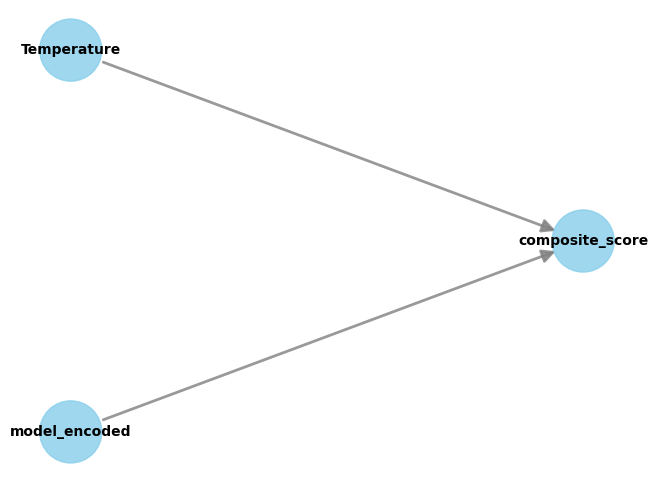

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
      d                           
──────────────(E[composite_score])
d[Temperature]                    
Estimand assumption 1, Unconfoundedness: If U→{Temperature} and U→composite_score then P(composite_score|Temperature,,U) = P(composite_score|Temperature,)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [8]:
model = CausalModel(
    data=causal_dataset_df,
    treatment=["Temperature"],
    outcome=["composite_score"],
    effect_modifiers=["model_encoded"],
)
model.view_model()

identified_estimand = model.identify_effect()
print(identified_estimand)

model_y = LinearRegression(fit_intercept=True)
model_t = LinearRegression(fit_intercept=True)

result_df = pd.DataFrame()
model_list = causal_dataset_df["model_encoded"].unique().tolist()
for control_value in control_values:
    dml_estimate = model.estimate_effect(
        identified_estimand,
        method_name="backdoor.econml.dml.LinearDML",
        confidence_intervals=True,
        control_value=control_value,
        treatment_value=control_value + step,
        method_params={
            "init_params": {
                "model_y": model_y,
                "model_t": model_t,
            }
        },
        fit_estimator=True,
    )
    for model_encoded in model_list:
        dml_estimate = model.estimate_effect(
            identified_estimand,
            method_name="backdoor.econml.dml.LinearDML",
            target_units=causal_dataset_df[
                causal_dataset_df["model_encoded"] == model_encoded
            ],
            confidence_intervals=True,
            control_value=control_value,
            treatment_value=control_value + step,
            method_params={
                "init_params": {
                    "model_y": model_y,
                    "model_t": model_t,
                }
            },
            fit_estimator=False,
        )
        estimate_value = dml_estimate.cate_estimates[0]
        lower_bound = dml_estimate.get_confidence_intervals()[:, :, 0][0][0]
        upper_bound = dml_estimate.get_confidence_intervals()[:, :, 0][1][0]
        data = {
            "lower_bound": lower_bound,
            "upper_bound": upper_bound,
            "estimate_value": estimate_value,
            "control_value": control_value,
            "model_encoded": model_encoded,
        }
        data_df = pd.DataFrame(data)
        result_df = pd.concat([result_df, data_df], ignore_index=True)

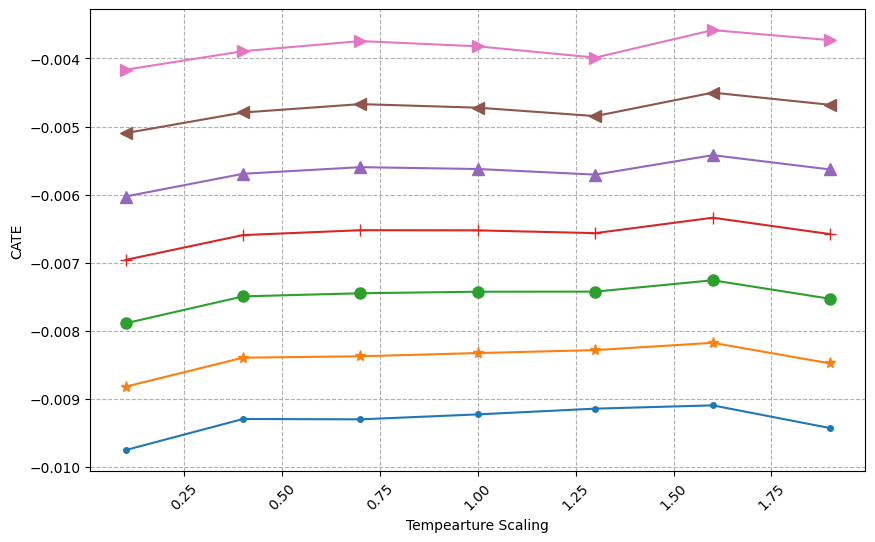

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

reversed_model_map = {value: key for key, value in model_map.items()}
result_df["control_value"] = result_df["control_value"].round(1)
result_df["model_name"] = result_df["model_encoded"].map(reversed_model_map)
grouped = result_df.groupby("model_name")

current_time = datetime.datetime.now()
current_time_str = current_time.strftime("%Y%m%d%H%M%S")
output_photo_name = f"ICL_{current_time_str}.svg"
plt.figure(figsize=(10, 6))
i = 0
for name, group in grouped:
    plt.plot(
        group["control_value"],
        group["estimate_value"],
        label=name,
        color=color_map[name],
        marker=marker_map[name],
        markersize=8,
    )
    i += 1
    # plt.fill_between(group['control_value'], group['lower_bound'], group['upper_bound'], alpha=0.01)
plt.grid(
    linestyle="--",
)
plt.xticks(rotation=45)
# plt.legend()

plt.xlabel("Tempearture Scaling")
plt.ylabel("CATE")
plt.savefig(output_photo_path, format="svg", bbox_inches="tight")
# plt.title("Estimate Value vs Control Value for Different Model Encodings")
plt.show()